# Training species classifier Expt 3: cross-validation of Oswald data
## Trained on all except the select data
## Four datasets: Oswald, Gillispie, DCLDE 2011 & Watkin


In [1]:
import numpy as np
from itertools import permutations
import random
import os
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd
from os import makedirs
from datetime import datetime

from math import floor

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
import seaborn as sns

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Conv2D, Lambda, Flatten, MaxPooling2D, Concatenate, LSTM, Reshape, Lambda, ConvLSTM2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
# import tensorflow_addons as tfa
# import tensorflow_datasets as tfds
from tensorflow.math import l2_normalize

from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

import tensorflow as tf

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Hyper parameters
learning_rate = 1.0e-4
conv_dim = 16
rnn_dim = 16
pool_size = 2
pool_stride = 2
l2_regu = 0.000
drop_rate = 0.2
hidden_units = 512
fcn_dim = 512

# learning_rate = 1.e-4
# conv_dim = 64
# rnn_dim = 16
# pool_size = 2
# pool_stride = 2
# l2_regu = 0.00
# drop_rate = 0.2
# # drop_rate = 0.5
# hidden_units = 512
# fcn_dim = 512

num_epoch = 200
# batch_size = 128
batch_size = 32  # for cnn14+attention

num_species = 21
num_patience = 20

In [4]:
# data_type_dict = {1: 'universal', 2: 'file', 3: 'encounter', 4: 'domain'}
# data_type = 2

work_path = '/home/ys587/__Data/__whistle/__whislte_30_species'
fit_result_path =  os.path.join(work_path, '__fit_result_species')
# feature_path = os.path.join(work_path, '__feature_species')
feature_path = os.path.join(work_path, '__dataset/20210210')

In [5]:
# species_dict = {'BD': 0, 'MH': 1, 'CD': 2, 'STR': 3, 'SPT': 4, 'SPIN': 5, 'PLT': 6, 'RD': 7, 'RT': 8,
#                 'WSD': 9, 'FKW': 10, 'BEL': 11, 'KW': 12, 'WBD': 13, 'DUSK': 14, 'FRA': 15, 'PKW': 16, 'LPLT': 17, }
species_dict = {'BD': 0, 'MH': 1, 'CD': 2, 'STR': 3, 'SPT': 4, 'SPIN': 5, 'PLT': 6, 'RD': 7, 'RT': 8,
                'WSD': 9, 'FKW': 10, 'BEL': 11, 'KW': 12, 'WBD': 13, 'DUSK': 14, 'FRA': 15, 'PKW': 16, 'LPLT': 17,
                'CLY': 18, 'SPE': 19, 'ASP': 20}
species_list = list(species_dict.keys())
species_id = list(species_dict.values())

In [6]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_no_oswald_STAR2000.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [7]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [8]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_STAR2000_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [9]:
fea_train = fea_train[:,:100,:]

In [10]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [11]:
from collections import Counter
Counter(label_train_list)

Counter({'BD': 40648,
         'CD': 31972,
         'FKW': 22152,
         'SPIN': 15240,
         'SPT': 21556,
         'STR': 17432,
         'PLT': 17280,
         'RT': 4980,
         'BEL': 1168,
         'DUSK': 2052,
         'FRA': 3288,
         'KW': 8064,
         'LPLT': 4320,
         'PKW': 228,
         'RD': 7412,
         'WSD': 16676,
         'WBD': 1608,
         'MH': 82272,
         'ASP': 360,
         'CLY': 904,
         'SPE': 27028})

In [12]:
Counter(label_test.tolist())

Counter({0.0: 121, 2.0: 3964, 6.0: 31, 8.0: 76, 5.0: 491, 4.0: 845, 3.0: 1140})

In [13]:
# create a folder based on date & time
today = datetime.now()

fit_result_path1 = os.path.join(fit_result_path, today.strftime('%Y%m%d_%H%M%S'))

if not os.path.exists(fit_result_path1):
    makedirs(fit_result_path1)

In [14]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (326640, 100, 128)
feature test shape: (6668, 100, 128)
label train shape: (326640,)
label test shape: (6668,)
dim_time: 100
dim_freq: 128


In [15]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [16]:
# data generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, feature, label, batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.X = feature
        self.X_dim = len(feature.shape)
        self.y = to_categorical(label, num_classes)
        self.indices = np.arange(self.y.shape[0])
        self.num_classes = num_classes
        self.shuffle = shuffle
        
        # self.index = np.arange(len(self.indices))
        #self.df = dataframe
        #self.indices = self.df.index.tolist()        
        # self.x_col = x_col
        # self.y_col = y_col
        
        self.on_epoch_end()

    def __len__(self):
        return int(floor(len(self.indices)/self.batch_size))
        # return label.shape[0]

    def __getitem__(self, index):
        # index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        # batch = [self.indices[k] for k in index]
        batch = list(range(index*self.batch_size, (index+1)*self.batch_size))
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        y = np.zeros((self.batch_size, self.y.shape[1]))
        
        if self.X_dim == 3:
            X = np.zeros((self.batch_size, self.X.shape[1], self.X.shape[2]))
            for i, id in enumerate(batch):
                X[i,:, :] = self.X[id, :, :]  # logic
                y[i, :] = self.y[id, :] # labels
                
        elif self.X_dim == 4:
            X = np.zeros((self.batch_size, self.X.shape[1], self.X.shape[2], self.X.shape[3]))
            for i, id in enumerate(batch):
                X[i,:, :, :] = self.X[id, :, :, :]  # logic
                y[i, :] = self.y[id, :] # labels

        return X, y

In [17]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [18]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.30, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


## Models

In [19]:
# Kong's attention
# def max_pooling(inputs, **kwargs):
#     input = inputs[0]   # (batch_size, time_steps, freq_bins)
#     return K.max(input, axis=1)
def max_pooling(inputs, **kwargs):
    # input = inputs[0]   # (batch_size, time_steps, freq_bins)
    return K.max(inputs, axis=1)


def average_pooling(inputs, **kwargs):
    input = inputs[0]   # (batch_size, time_steps, freq_bins)
    return K.mean(input, axis=1)


def attention_pooling(inputs, **kwargs):
    [out, att] = inputs

    epsilon = 1e-7
    att = K.clip(att, epsilon, 1. - epsilon)
    normalized_att = att / K.sum(att, axis=1)[:, None, :]

    return K.sum(out * normalized_att, axis=1)


def pooling_shape(input_shape):

    if isinstance(input_shape, list):
        (sample_num, time_steps, freq_bins) = input_shape[0]

    else:
        (sample_num, time_steps, freq_bins) = input_shape

    return (sample_num, freq_bins)

In [20]:
# cnn14 attention with customized maxpooling
def model_cnn14_attention_multi(time_steps, freq_bins, classes_num, model_type='feature_level_attention', conv_dim=64, rnn_dim=128, pool_size=2, pool_stride=2, hidden_units=512, l2_regu=0., drop_rate=0., multilabel=True):
    # Kong's attention
    # model_type = 'decision_level_max_pooling'  # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_average_pooling' # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_single_attention'
    # model_type = 'decision_level_multi_attention'
    # model_type = 'feature_level_attention'

    input_layer = Input(shape=(time_steps, freq_bins, 1), name='input')
    # group 1
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(input_layer)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 2
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 3
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 4 
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 5
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(1, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 6
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(1, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # change dimensions: samples, time, frequency, channels => samples, time, frequency*channels
    dim_cnn = K.int_shape(y)
    y = Reshape((dim_cnn[1], dim_cnn[2]*dim_cnn[3]))(y)

    a1 = Dense(hidden_units)(y)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    a1 = Dropout(drop_rate)(a1)

    a2 = Dense(hidden_units)(a1)
    a2 = BatchNormalization()(a2)
    a2 = Activation('relu')(a2)
    a2 = Dropout(drop_rate)(a2)

    a3 = Dense(hidden_units)(a2)
    a3 = BatchNormalization()(a3)
    a3 = Activation('relu')(a3)
    a3 = Dropout(drop_rate)(a3)

    # Pooling layers
    if model_type == 'decision_level_max_pooling':
        '''Global max pooling.

        [1] Choi, Keunwoo, et al. "Automatic tagging using deep convolutional 
        neural networks." arXiv preprint arXiv:1606.00298 (2016).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        
        # output_layer = Lambda(
        #    max_pooling, 
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(max_pooling)(cla)

    elif model_type == 'decision_level_average_pooling':
        '''Global average pooling.

        [2] Lin, Min, et al. Qiang Chen, and Shuicheng Yan. "Network in 
        network." arXiv preprint arXiv:1312.4400 (2013).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        # output_layer = Lambda(
        #    average_pooling,
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(average_pooling)(cla)

    elif model_type == 'decision_level_single_attention':
        '''Decision level single attention pooling.
        [3] Kong, Qiuqiang, et al. "Audio Set classification with attention
        model: A probabilistic perspective." arXiv preprint arXiv:1711.00927
        (2017).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        att = Dense(classes_num, activation='softmax')(a3)
        output_layer = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

    elif model_type == 'decision_level_multi_attention':
        '''Decision level multi attention pooling.
        [4] Yu, Changsong, et al. "Multi-level Attention Model for Weakly
        Supervised Audio Classification." arXiv preprint arXiv:1803.02353
        (2018).
        '''
        cla1 = Dense(classes_num, activation='sigmoid')(a2)
        att1 = Dense(classes_num, activation='softmax')(a2)
        out1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla1, att1])

        cla2 = Dense(classes_num, activation='sigmoid')(a3)
        att2 = Dense(classes_num, activation='softmax')(a3)
        out2 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla2, att2])

        b1 = Concatenate(axis=-1)([out1, out2])
        b1 = Dense(classes_num)(b1)
        
        if multilabel:
            output_layer = Activation('sigmoid')(b1)
        else:
            output_layer = Activation('softmax')(b1)

    elif model_type == 'feature_level_attention':
        '''Feature level attention.
        [1] Kong, Qiuqiang, et al. "Weakly labelled audioset tagging with 
        attention neural networks." (2019).
        '''
        cla = Dense(hidden_units, activation='linear')(a3)
        att = Dense(hidden_units, activation='sigmoid')(a3)
        b1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

        b1 = BatchNormalization()(b1)
        b1 = Activation(activation='relu')(b1)
        b1 = Dropout(drop_rate)(b1)
        
        if multilabel:
            output_layer = Dense(classes_num, activation='sigmoid')(b1)
        else:
            output_layer = Dense(classes_num, activation='softmax')(b1)

    else:
        raise Exception("Incorrect model_type!")

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [21]:
# cnn14 attention
def model_cnn14_attention(time_steps, freq_bins, classes_num, model_type='feature_level_attention', conv_dim=64, rnn_dim=128, pool_size=2, pool_stride=2, hidden_units=512, l2_regu=0., drop_rate=0., multilabel=True):
    # Kong's attention
    # model_type = 'decision_level_max_pooling'  # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_average_pooling' # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_single_attention'
    # model_type = 'decision_level_multi_attention'
    # model_type = 'feature_level_attention'

    input_layer = Input(shape=(time_steps, freq_bins, 1), name='input')
    # group 1
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(input_layer)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 2
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 3
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 4 
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 5
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 6
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # change dimensions: samples, time, frequency, channels => samples, time, frequency*channels
    dim_cnn = K.int_shape(y)
    y = Reshape((dim_cnn[1], dim_cnn[2]*dim_cnn[3]))(y)

    a1 = Dense(hidden_units)(y)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    a1 = Dropout(drop_rate)(a1)

    a2 = Dense(hidden_units)(a1)
    a2 = BatchNormalization()(a2)
    a2 = Activation('relu')(a2)
    a2 = Dropout(drop_rate)(a2)

    a3 = Dense(hidden_units)(a2)
    a3 = BatchNormalization()(a3)
    a3 = Activation('relu')(a3)
    a3 = Dropout(drop_rate)(a3)

    # Pooling layers
    if model_type == 'decision_level_max_pooling':
        '''Global max pooling.

        [1] Choi, Keunwoo, et al. "Automatic tagging using deep convolutional 
        neural networks." arXiv preprint arXiv:1606.00298 (2016).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        
        # output_layer = Lambda(
        #    max_pooling, 
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(max_pooling)(cla)

    elif model_type == 'decision_level_average_pooling':
        '''Global average pooling.

        [2] Lin, Min, et al. Qiang Chen, and Shuicheng Yan. "Network in 
        network." arXiv preprint arXiv:1312.4400 (2013).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        # output_layer = Lambda(
        #    average_pooling,
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(average_pooling)(cla)

    elif model_type == 'decision_level_single_attention':
        '''Decision level single attention pooling.
        [3] Kong, Qiuqiang, et al. "Audio Set classification with attention
        model: A probabilistic perspective." arXiv preprint arXiv:1711.00927
        (2017).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        att = Dense(classes_num, activation='softmax')(a3)
        output_layer = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

    elif model_type == 'decision_level_multi_attention':
        '''Decision level multi attention pooling.
        [4] Yu, Changsong, et al. "Multi-level Attention Model for Weakly
        Supervised Audio Classification." arXiv preprint arXiv:1803.02353
        (2018).
        '''
        cla1 = Dense(classes_num, activation='sigmoid')(a2)
        att1 = Dense(classes_num, activation='softmax')(a2)
        out1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla1, att1])

        cla2 = Dense(classes_num, activation='sigmoid')(a3)
        att2 = Dense(classes_num, activation='softmax')(a3)
        out2 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla2, att2])

        b1 = Concatenate(axis=-1)([out1, out2])
        b1 = Dense(classes_num)(b1)
        
        if multilabel:
            output_layer = Activation('sigmoid')(b1)
        else:
            output_layer = Activation('softmax')(b1)

    elif model_type == 'feature_level_attention':
        '''Feature level attention.
        [1] Kong, Qiuqiang, et al. "Weakly labelled audioset tagging with 
        attention neural networks." (2019).
        '''
        cla = Dense(hidden_units, activation='linear')(a3)
        att = Dense(hidden_units, activation='sigmoid')(a3)
        b1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

        b1 = BatchNormalization()(b1)
        b1 = Activation(activation='relu')(b1)
        b1 = Dropout(drop_rate)(b1)
        
        if multilabel:
            output_layer = Dense(classes_num, activation='sigmoid')(b1)
        else:
            output_layer = Dense(classes_num, activation='softmax')(b1)

    else:
        raise Exception("Incorrect model_type!")

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [22]:
def model_cnn14(time_steps, freq_bins, classes_num, pool_size=2, pool_stride=2, conv_dim=16, fcn_dim=512, l2_regu=0., drop_rate=0.):
    # input
    input_layer = Input(shape=(time_steps, freq_bins, 1), name='input')
    
    # group 1
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(input_layer)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 2
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 3
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 4 
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 5
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 6
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    
    y = GlobalMaxPooling2D()(y)
    
    # FC block
    y = Dense(fcn_dim, activation='relu', name='cnn14_fcn')(y)  # original 512
    x = Dense(classes_num, activation='softmax')(y)
    
    # Build model
    model = Model(inputs=input_layer, outputs=x)
    
    return model

# Model compile, class weight & fitting

In [23]:
# def find_best_model(model_folder, remove_others=False):
#     model_list = glob.glob(model_folder+'/*.hdf5')
#     model_list.sort()
#     the_best_model = model_list[-1]
    
#     if remove_others==True:
#         for mm in model_list[:-1]:
#             os.remove(mm)
            
#     print(the_best_model)
    
#     return the_best_model
import re

def find_best_model(classifier_path, fmt='epoch_\d+_valloss_(\d+.\d{4})_valacc_\d+.\d{4}.hdf5', is_max=False, purge=True):
    """
    Return the path to the model with the best accuracy, given the path to
    all the trained classifiers
    Args:
        classifier_path: path to all the trained classifiers
        fmt: e.g. "epoch_\d+_[0-1].\d+_(\d+.\d{4}).hdf5"
        'epoch_\d+_valloss_(\d+.\d{4})_valacc_\d+.\d{4}.hdf5'
        is_max: use max; otherwise, min
        purge: True to purge models files except the best one
    Return:
        the path of the model with the best accuracy
    """
    # list all files ending with .hdf5
    day_list = sorted(glob.glob(os.path.join(classifier_path + '/', '*.hdf5')))

    # re the last 4 digits for accuracy
    hdf5_filename = []
    hdf5_accu = np.zeros(len(day_list))
    for dd in range(len(day_list)):
        filename = os.path.basename(day_list[dd])
        hdf5_filename.append(filename)
        # m = re.search("_F1_(0.\d{4}).hdf5", filename)
        # m = re.search("_([0-1].\d{4}).hdf5", filename)
        # m = re.search("epoch_\d+_[0-1].\d+_(\d+.\d{4}).hdf5", filename)
        m = re.search(fmt, filename)
        try:
            hdf5_accu[dd] = float(m.groups()[0])
        except:
            continue

    # select the laregest one and write to the variable classifier_file
    if len(hdf5_accu) == 0:
        best_model_path = ''
        best_accu = 0
    else:
        if is_max is True:
            ind_max = np.argmax(hdf5_accu)
        else: # use min instead
            ind_max = np.argmin(hdf5_accu)
        best_model_path = day_list[int(ind_max)]
        best_accu = hdf5_accu[ind_max]
        # purge all model files except the best_model
        if purge:
            for ff in day_list:
                if ff != best_model_path:
                    os.remove(ff)
    print('Best model:'+str(best_accu))
    print(best_model_path)
    return best_model_path, best_accu


In [24]:
### cnn4 + attention
# model = model_cnn_attention(dim_time, dim_freq, num_species, model_type='decision_level_max_pooling', conv_dim=conv_dim, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn_attention(dim_time, dim_freq, num_species, model_type='decision_level_multi_attention', conv_dim=conv_dim, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn_attention(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, l2_regu=l2_regu, drop_rate=drop_rate)

# vggish
# model = model_vggish(dim_time, dim_freq, num_species, conv_dim=conv_dim, fcn_dim=fcn_dim)

# cnn10
# model = model_cnn10(dim_time, dim_freq, num_species, conv_dim=conv_dim, fcn_dim=fcn_dim, l2_regu=l2_regu, drop_rate=drop_rate)

# cnn14
# model = model_cnn14(dim_time, dim_freq, num_species, conv_dim=conv_dim, fcn_dim=fcn_dim, l2_regu=l2_regu, drop_rate=drop_rate)

# cnn14 attention
# model = model_cnn14_attention(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn14_bigru_attention(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, rnn_dim=rnn_dim, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)

loss = CategoricalCrossentropy()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=['accuracy'])

# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [25]:
# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])

Epoch 1/200
7144/7145 [============================>.] - ETA: 0s - loss: 2.6217 - accuracy: 0.2190
Epoch 00001: val_loss improved from inf to 2.14424, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210211_120511/epoch_01_valloss_2.1442_valacc_0.3759.hdf5
7145/7145 [==============================] - 232s 32ms/step - loss: 2.6216 - accuracy: 0.2190 - val_loss: 2.1442 - val_accuracy: 0.3759
Epoch 2/200
7144/7145 [============================>.] - ETA: 0s - loss: 1.9739 - accuracy: 0.3637
Epoch 00002: val_loss improved from 2.14424 to 1.77832, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210211_120511/epoch_02_valloss_1.7783_valacc_0.4427.hdf5
7145/7145 [==============================] - 232s 32ms/step - loss: 1.9738 - accuracy: 0.3637 - val_loss: 1.7783 - val_accuracy: 0.4427
Epoch 3/200
7145/7145 [==============================] - ETA: 0s - loss: 1.6197 - accuracy: 0.4492
Epoch 00003: val_loss improved 

KeyboardInterrupt: 

In [26]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path1, purge=False)

Best model:0.347
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210211_120511/epoch_67_valloss_0.3470_valacc_0.8832.hdf5


In [27]:
model = load_model(the_best_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 100, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 128, 16) 160         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [28]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [29]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [30]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'MH', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RD', 'RT', 'WSD', 'FKW', 'BEL', 'KW', 'WBD', 'DUSK', 'FRA', 'PKW', 'LPLT', 'CLY', 'SPE', 'ASP']

[[  39    2   12    9   23   12    3    0    3    9    2    0    0    0    0    4    0    2    0    1    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [ 621  455 1764  386  308  121  160   12   24   38   13    1    1    6    0   23    1   15    0    4   11]
 [ 298   29  194  202  217   70   66    1   21   12    5    0    0    5    0   13    0    0    1    3    3]
 [  67   75  500   15   99   53   15    0    2    5    1    0    0    1    0    5    0    0    6    1    0]
 [ 155    3   26   30  111  148    3    0    0    1    0    0    0    0    1    2    0    0    1    0   10]
 [   0    0    0    0    0    0   24    0    0    0    4    0    0    0    0    0    0    3    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    

In [31]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

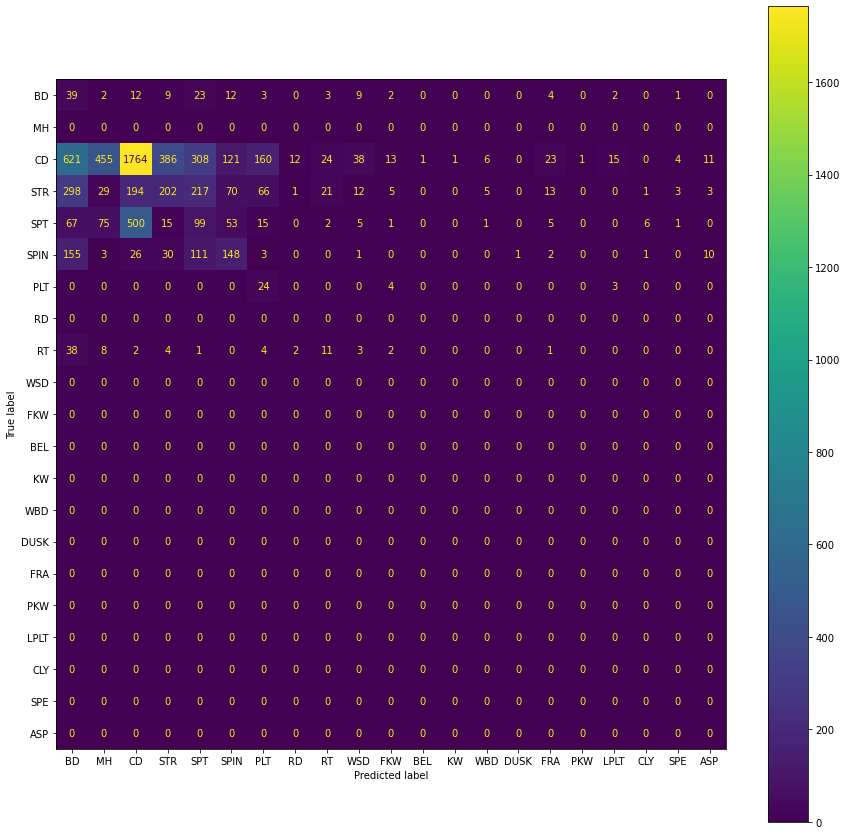

In [32]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


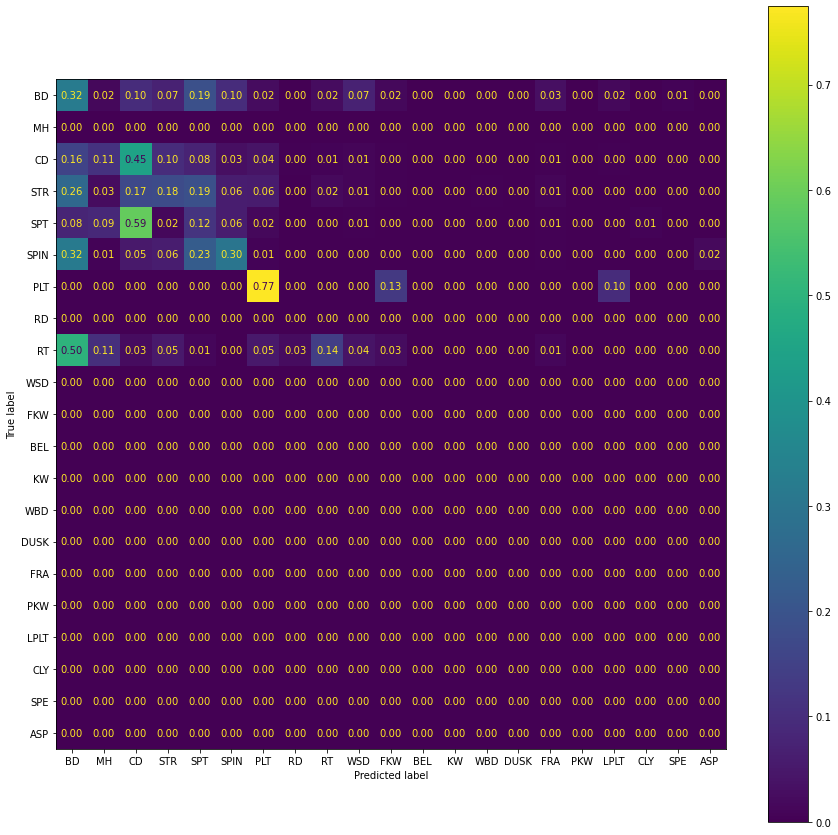

In [33]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

In [ ]:
# part of training data
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_part1_orig.npz'))
fea_test2 = fea_temp['feas_orig']
label_test_list2 = fea_temp['labels_orig']

fea_test2 = fea_test2[:,:100,:]
label_test2 = np.zeros(len(label_test_list2))
for ii in range(len(label_test_list2)):
    label_test2[ii] = species_dict[label_test_list2[ii]]

In [ ]:
the_best_model, _ = find_best_model(fit_result_path1, purge=False)
del model
model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = load_model(the_best_model)
label_pred2 = model.predict(fea_test2)

In [ ]:
print("Confusion matrix:")
cm = confusion_matrix(label_test2, np.argmax(label_pred2, axis=1))
    
print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

## learning rate scheduler
step = tf.Variable(0, trainable=False)
boundaries = [10, 20]
values = [1.0e-4, 3.3e-5, 1.0e-5]
learning_rate_fn = PiecewiseConstantDecay(boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
# learning_rate = learning_rate_fn(step)

### if False:
    # fea_files = ['oswald_part1_orig.npz', 'oswald_part1_aug.npz', 'oswald_part2_orig.npz', 'oswald_part2_aug.npz',
    #             'gillispie_48kHz_orig.npz', 'gillispie_48kHz_aug.npz', 'gillispie_96kHz_orig.npz', 'gillispie_48kHz_aug.npz',
    #             'dclde2011_orig.npz', 'dclde2011_aug.npz', 'watkin_orig.npz', 'watkin_aug.npz']

    # Expt 1: test on oswald_part1
    fea_train_files = ['oswald_part1_orig.npz', 'oswald_part1_aug.npz',
                'gillispie_48kHz_orig.npz', 'gillispie_48kHz_aug.npz', 'gillispie_96kHz_orig.npz', 'gillispie_96kHz_aug.npz',
                'dclde2011_orig.npz', 'dclde2011_aug.npz', 'watkin_orig.npz', 'watkin_aug.npz']

    fea_test_files = ['oswald_part2_orig.npz']

    # Training data
    fea_train_list = []
    label_train_list = []
    for ii in range(len(fea_train_files)):
        ff = fea_train_files[ii]
        print(ff)
        fea_temp = np.load(os.path.join(feature_path, ff))
        print(fea_temp.files)

        if ii == 0:
            fea_train = fea_temp['feas_orig']
            label_train = fea_temp['labels_orig']
            print(fea_train.shape)
            print(label_train.shape)
        elif ii % 2 == 0:  # even
            fea_train = np.concatenate([fea_train, fea_temp['feas_orig']])
            label_train = np.concatenate([label_train, fea_temp['labels_orig']])
            print(fea_train.shape)
            print(label_train.shape)
        else:
            fea_train = np.concatenate([fea_train, fea_temp['feas_aug']])
            label_train = np.concatenate([label_train, fea_temp['labels_aug']])
            print(fea_train.shape)
            print(label_train.shape)
        print('')